# SpectralClustering and DBSCAN with minHash

In [1]:
%matplotlib inline
%load_ext memory_profiler
import time
from memory_profiler import memory_usage


from eden.converter.graph.gspan import gspan_to_eden
from eden.path import Vectorizer

import numpy as np

from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics.cluster import adjusted_rand_score

# import everything which is needed for the clustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from neighborsMinHash.clustering import MinHashClustering 
from neighborsMinHash import MinHash

import matplotlib.pyplot as plt

In [2]:
#code for making artificial dataset
import random
def random_string(length,alphabet_list):
    rand_str = ''.join(random.choice(alphabet_list) for i in range(length))
    return rand_str

def perturb(seed,alphabet_list,p=0.5):
    seq=''
    for c in seed:
        if random.random() < p: c = random.choice(alphabet_list)
        seq += c
    return seq

def make_artificial_dataset(alphabet='ACGU', motives=None, motif_length=6, 
                            sequence_length=100, n_sequences=1000, n_motives=2, p=0.2):
    alphabet_list=[c for c in alphabet]
    
    if motives is None:
        motives=[]
        for i in range(n_motives):
            motives.append(random_string(motif_length,alphabet_list))
    else:
        motif_length = len(motives[0])
        n_motives = len(motives)
        
    flanking_length = (sequence_length - motif_length ) / 2
    n_seq_per_motif = n_sequences / n_motives

    counter=0
    seqs=[]
    targets = []
    for i in range(n_seq_per_motif):
        for j in range(n_motives):
            targets.append(j)
            left_flanking = random_string(flanking_length,alphabet_list)
            right_flanking = random_string(flanking_length,alphabet_list)
            noisy_motif = perturb(motives[j],alphabet_list,p)
            seq = left_flanking + noisy_motif + right_flanking
            seqs.append(('>ID%d'%counter,seq))
            counter += 1
    return motives, seqs, targets

In [3]:
#setup parameters
alphabet='ACGU'
motif_length = 20
motives=['A'*motif_length,'C'*motif_length,'G'*motif_length,'U'*motif_length]
sequence_length=3 * motif_length
n_sequences=5000
p=0.3

#make dataset
motives_2, seqs, targets = make_artificial_dataset(alphabet=alphabet,motives=motives,
                                        sequence_length=sequence_length,n_sequences=n_sequences,p=p)

In [4]:
%%time
vectorizer = Vectorizer(complexity=3, nbits=20)
dataset_sparse = vectorizer.transform(seqs)

CPU times: user 18 s, sys: 280 ms, total: 18.2 s
Wall time: 18.2 s


In [5]:
pairwise_distances_ = pairwise_distances(X=dataset_sparse, metric='euclidean', n_jobs=4)
average_value = np.average(pairwise_distances_)
standard_deviation = np.std(pairwise_distances_)
eps = average_value + standard_deviation
min_ = np.min(pairwise_distances_)
max_ = np.max(pairwise_distances_)

In [6]:
print min_
print max_
print average_value
print standard_deviation
eps = min_ + standard_deviation

0.0
1.38707233756
1.17547429057
0.136764225521


(array([  5.00000000e+03,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        

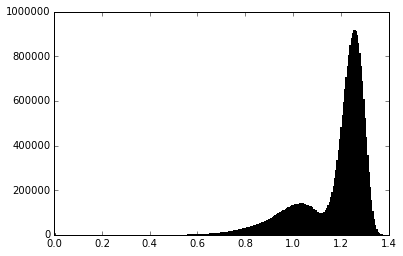

In [7]:
plt.hist(pairwise_distances_.ravel(), bins=256, range=(min_, max_), fc='k', ec='k')

In [8]:
eps_factor = 1
eps = 1.3
clustering_names = [
    'SpectralClustering', 'MinHashSpectralClustering', 'DBSCAN', 'MinHashDBSCAN']

# original algorithms
spectral = SpectralClustering(n_clusters=4, eigen_solver='arpack',
                                      affinity="nearest_neighbors", n_neighbors=5)
dbscan = DBSCAN(eps=eps*eps_factor, metric="euclidean")

# objects used for algorithms with precomputed minHash
minHash0 = MinHash(n_neighbors=5, similarity=False)
minHash1 = MinHash(n_neighbors=5, similarity=True)

spectral_precomputed = SpectralClustering(n_clusters=4, eigen_solver='arpack',
                                      affinity="precomputed", n_neighbors=5)

dbscan_precomputed = DBSCAN(eps=eps*eps_factor, metric='precomputed')


minHashClusteringSpectralClustering = MinHashClustering(minHash0, spectral_precomputed)
minHashClusteringDBSCAN = MinHashClustering(minHash1, dbscan_precomputed)

clustering_algorithms=[spectral, minHashClusteringSpectralClustering, dbscan, minHashClusteringDBSCAN]

In [9]:
%%time
X = dataset_sparse
for name, algorithm in zip(clustering_names, clustering_algorithms):
    print "\n"
    %time %memit y_pred = algorithm.fit_predict(X)
    y_pred = y_pred.astype(np.int)
    print name, ":\tARS: ", float("{0:.2f}".format(adjusted_rand_score(targets, y_pred)))



peak memory: 1167.17 MiB, increment: 563.87 MiB
CPU times: user 17.5 s, sys: 196 ms, total: 17.7 s
Wall time: 17.8 s
SpectralClustering :	ARS:  0.33


peak memory: 996.78 MiB, increment: 392.28 MiB
CPU times: user 1min 16s, sys: 304 ms, total: 1min 16s
Wall time: 55.4 s
MinHashSpectralClustering :	ARS:  0.01


peak memory: 1467.88 MiB, increment: 638.59 MiB
CPU times: user 14.9 s, sys: 204 ms, total: 15.1 s
Wall time: 15.2 s
DBSCAN :	ARS:  0.0


peak memory: 915.56 MiB, increment: 85.77 MiB
CPU times: user 29.4 s, sys: 332 ms, total: 29.7 s
Wall time: 8.84 s
MinHashDBSCAN :	ARS:  0.0
CPU times: user 2min 17s, sys: 1.04 s, total: 2min 18s
Wall time: 1min 37s


In [13]:
%%time
X = dataset_sparse
step = max / float(10)
eps = min + step
max_ars = 0
eps_max = 0
for i in xrange(10):
#     print "\neps: ", eps
#     minHash1 = MinHash(n_neighbors=5, similarity=True)
#     dbscan_precomputed = DBSCAN(eps=eps, metric='precomputed')
#     minHashClusteringDBSCAN = MinHashClustering(minHash1, dbscan_precomputed)
    dbscan = DBSCAN(eps=eps, metric="euclidean")
    y_pred = dbscan.fit_predict(X)
    y_pred = y_pred.astype(np.int)
#     print name, ":\tARS: ", float("{0:.2f}".format(adjusted_rand_score(targets, y_pred)))
    ars = adjusted_rand_score(targets, y_pred)
    if (ars > max_ars):
        max_ars = ars
        eps_max = eps
    eps += step
    print i
print "Maximal ARS: ", max_ars, " for eps: ", eps_max

0
1
2
3
4
5
6
7
8
9
Maximal ARS:  0.236755475576  for eps:  0.830826732906
CPU times: user 2min 20s, sys: 920 ms, total: 2min 20s
Wall time: 2min 20s


---